In [394]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; import pandas as pd 
import os ; import theano.tensor as tt
# Colums of data
# Data
cwd = os.chdir("/Users/danbarfod/Downloads/TCR_+_ACS")
df = pd.read_csv("mix_tcr_acs.csv", engine = 'python')
# DATA
age = df.iloc[:,0:1]
age_err = df.iloc[:,1:2]
a40 = df.iloc[:,2:3]
a39 = df.iloc[:,3:4]
a37 = df.iloc[:,4:5]
a36 = df.iloc[:,5:6]
temp = df.iloc[:,6:7]
age = age.values
age_err = age_err.values
a40 = a40.values
a39 = a39.values
a37 = a37.values
a36 = a36.values
temp = temp.values
age = age[age >=0]
age_err = age_err[age_err !=0]
a40 = a40[a40 >= 0]
a39 = a39[a39 >= 0]
a37 = a37[a37 >= 0]
a36 = a36[a36 >= 0]
temp = temp[temp >= 0]
time= 300*np.ones(len(temp))
data = age

sns.set_style('ticks')
# Plotting Parameters Fonts
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)


In [395]:
import theano 
from theano import shared, tensor as tt

In [396]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [397]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [398]:
def fracrel(a):
    y = np.cumsum(a)
    z = y/y.max()
    return z
data2 = fracrel(a39)

# Age Spectra and Fractional Release

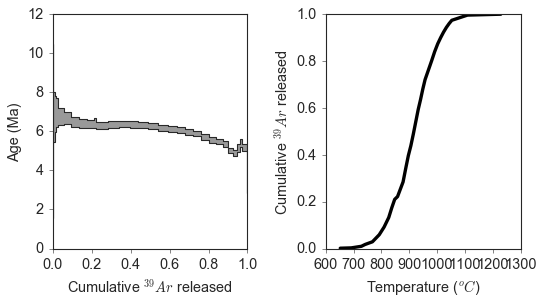

In [399]:
import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots(1,2, figsize = (7,4))
ax[0].fill_between(data2, data - age_err, data + age_err, 
                  step = 'pre', facecolor = 'grey', alpha = 0.8, 
                  edgecolor = 'k')
ax[0].set_xlabel('Cumulative $^{39}Ar$ released')
ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlim(0, 1)
ax[1].plot(temp, data2, lw = 3, color= 'k')
ax[1].set_ylabel('Cumulative $^{39}Ar$ released')
ax[1].set_xlabel('Temperature ($^{o}C$)')
plt.tight_layout()

In [400]:
tempk = temp + 273.15
time 
N = data.shape[0]
err_age = shared(age_err)
t_obs = time

In [401]:
marty = pm.Model()
import pymc3.distributions.transforms as tr
with marty: 
    
    # Mixing Coeff
    phi_m = pm.Dirichlet('phi_m', a =np.array([0.75, 0.25]),
                         shape = 2)
    
    pm.Potential('phi_con', 
                tt.switch(phi_m.min() < 0.1, 
                          -np.inf, 0))
                 

    # Diffusion Kinetics 
    ea1 = pm.Normal('ea1', mu = 220,
                    sd = 5)
    ea2 = pm.Normal('ea2', mu = 220,
                    sd = 5)

    d01 = pm.Lognormal('d01', -3, 1)
    d02 = pm.Lognormal('d02', -3, 1)
    
    # Effective Diffusion length scale (grain radii)
    a1 = pm.TruncatedNormal('a1', mu = 0.002, sd = 0.001, 
                           lower = 0.001, upper = 0.0032)
    a2 = pm.TruncatedNormal('a2', mu = 0.002, sd = 0.001, 
                           lower = 0.001, upper = 0.0032)
    
    
    lnd01a1 = pm.Deterministic('lnd01a1', 
                               tt.log(d01/a1))
    
    lnd02a2 = pm.Deterministic('lnd02a2', 
                               tt.log(d02/a2))

In [402]:
with marty: 
    # Deterministic
    # Cumulative Release 
    A = fracrelx(ea1,d01, a1, tempk, t_obs)

    B = fracrelx(ea2, d02, a2, tempk, t_obs)

    # Phi_m is under an Additive sum to 1 constraint
    m1 = phi_m[0]
    m2 = phi_m[1]
   # Cumulative Release Model 
    
    mu1 = m1*A + m2*B

# MONOTONIC Constraint
######################################################################
    for i in range(len(tempk) -1): 
        F_con1 = pm.Potential(f'F_con1{i}', 
                             tt.switch(A[i + 1] - A[i] <0, 
                                      -np.inf, 0) + 
                             tt.switch(B[i +1] - B[i] < 0, 
                                      -np.inf, 0))

    for i in range(len(tempk) -1): 
        F_con2 = pm.Potential(f'F_con2{i}', 
                             tt.switch(mu1[i + 1] - mu1[i] <0, 
                                      -np.inf, 0))
        
    # Constraint to the fractional release model 
    frac_rel_cons = pm.Potential('frac_rel_cons', 
                                tt.switch(mu1 >1, -np.inf, 0))
######################################################################    

In [403]:
with marty: 
    # Incremental Curves 
    
    i1 = Increment(ea1, d01, a1, tempk, t_obs)
    i2 = Increment(ea2, d02, a2, tempk, t_obs)
    
    phi1 = pm.Deterministic('phi1', (m1*i1)/(m1*i1 + m2*i2))
    
    phi2 = pm.Deterministic('phi2', (m2*i2)/(m1*i1 + m2*i2))

 

In [404]:
with marty: 
    
    
    age1 = pm.Uniform('age1', lower = 0.0,
                      upper = 4600)
    age2 = pm.Uniform('age2', lower = 0.0,
                      upper = 4600)
    


In [405]:
with marty: 
     # Age Spectra Model 
    model2 = (phi1*age1) + (phi2*age2)
    
    # Age model error 
    age_model_err = pm.HalfNormal('age_model_err', 
                                 sd = 5)

In [406]:
with marty: 
    # Cumulative Release Error 
    f_err = pm.HalfNormal('f_err', sd = 5)

In [407]:
with marty: 

    L1 = pm.Normal('L1', mu = mu1, 
                  sd = f_err, 
                  observed = data2)
    
    L2 = pm.Normal('L2', mu = model2, 
                  sd = age_model_err, 
                  observed = data)
    

In [408]:
marty.check_test_point()
    

phi_m_stickbreaking__     -2.05
ea1                       -2.53
ea2                       -2.53
d01_log__                 -0.92
d02_log__                 -0.92
a1_interval__             -1.20
a2_interval__             -1.20
age1                      -0.23
age2                       1.67
age_model_err_log__       -0.77
f_err_log__               -0.77
L1                       -73.89
L2                      -316.60
Name: Log-probability of test_point, dtype: float64

In [409]:
SEED = np.random.seed(123)
with marty: 

    trace = pm.sample(100000, 
                      tune = 150000,
                      step = pm.Metropolis(),
                     random_seed = SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [f_err]
>Metropolis: [age_model_err]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [d02]
>Metropolis: [d01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi_m]
Sampling 4 chains: 100%|██████████| 1000000/1000000 [36:00<00:00, 170.67draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Traceplot

In [410]:
print(trace['age1'][-1000:].mean(axis = 0))
print(trace['age2'][-1000:].mean(axis = 0))

print(2*np.std(trace['age1'][-1000:]))
print(2*np.std(trace['age2'][-1000:]))

28.197344072330903
1.2143013374244205
1.1182310907833122
0.16170650363708722


In [411]:
with marty: 
    ppc = pm.sample_ppc(trace[-10000:], 
                       10000)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 10000/10000 [01:16<00:00, 130.69it/s]


In [412]:
f_model = ppc['L1'].mean(axis = 0)
age_model = ppc['L2'].mean(axis = 0)

low1, high1 = np.percentile(ppc['L1'], 
                           [2.5, 97.5], 
                           axis = 0)

low2, high2 = np.percentile(ppc['L2'], 
                           [2.5, 97.5], 
                           axis = 0)

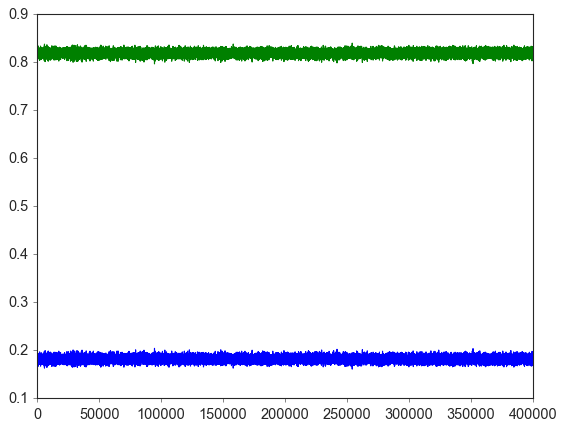

In [413]:
plt.plot(trace['phi_m']); 

## Model Checks

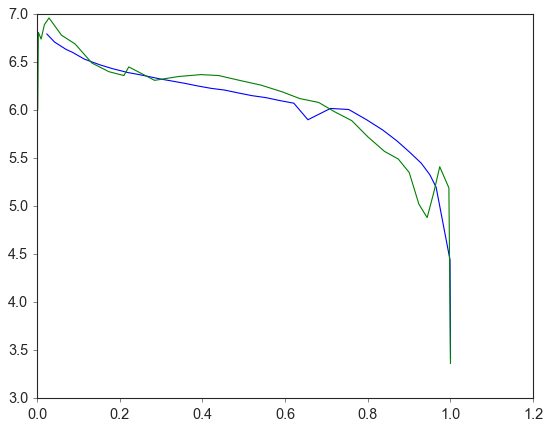

In [414]:
x1 = f_model
y1 = age_model
plt.plot(x1, y1)
plt.plot(data2, data)

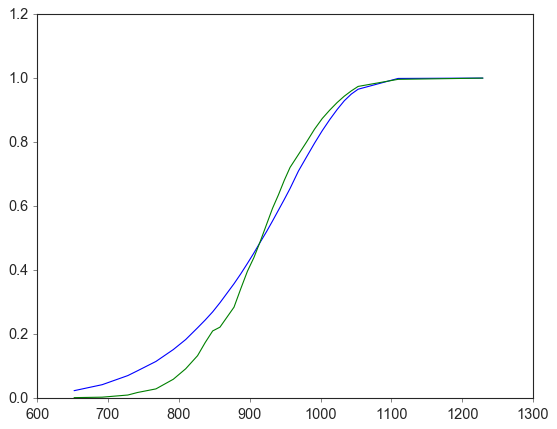

In [415]:
plt.plot(temp, x1)
plt.plot(temp, data2)

In [416]:
# Mean Posterior Models

Z1 = f_model
Z2 = age_model

In [417]:

# Plotting Parameters Fonts
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 19}

plt.rc('font', **font)
sns.set_style('ticks')

## Plotting Parameters Fonts

In [418]:

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8.5}

plt.rc('font', **font)
sns.set_style('ticks')

# Fractional release plot

In [419]:
err_frel = trace['f_err'].mean(axis = 0)

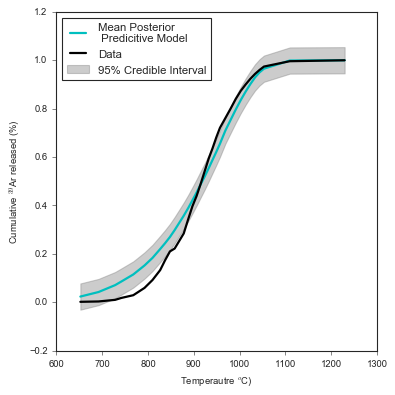

In [420]:
plt.figure(figsize = (5,5))
plt.fill_between(temp, Z1 - err_frel, Z1 + err_frel, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.tight_layout()

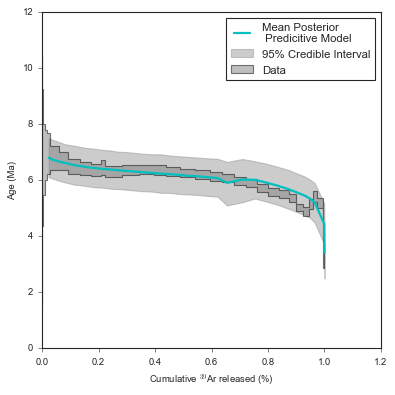

In [421]:
plt.figure(figsize = (5,5))
plt.fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.tight_layout()

# Combined

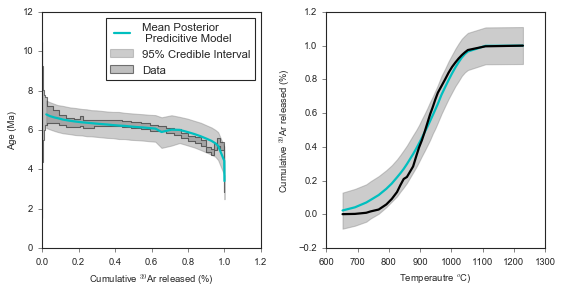

In [422]:

fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[0].plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()

# Final plots for Model

In [423]:
# Plotting parameters
f_model = ppc['L1'].mean(axis = 0)
age_model = ppc['L2'].mean(axis = 0)

low1, high1 = np.percentile(ppc['L1'], 
                           [2.5, 97.5], 
                           axis = 0)

low2, high2 = np.percentile(ppc['L2'], 
                           [2.5, 97.5], 
                           axis = 0)

# Model plotting parameters
age_low_plot = np.insert(low2, 0, low2[0])
age_high_plot = np.insert(high2,0, high2[0])

f_mod_plot = np.insert(f_model, 0, 0)

model_plot = np.insert(age_model, 0, age_model[0])

# Data Plotting
data_age_plot = np.insert(data, 0, data[0])
data_age_err_plot = np.insert(age_err, 0, age_err[0])
f_data_plot = np.insert(data2,0 ,0 )

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


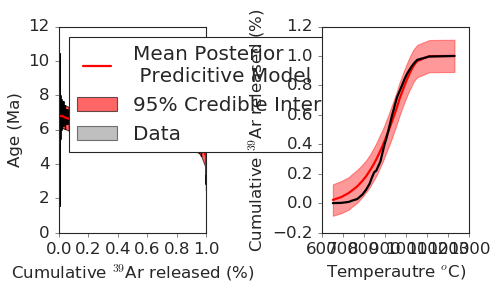

In [432]:
sns.set_style('ticks')
# Plotting Parameters Fonts
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)


fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(f_mod_plot,age_low_plot,
                   age_high_plot,
                   alpha = 0.6, 
                   facecolor = 'r', 
                   edgecolor = 'k',
                   label = '95% Credible Interval')
ax[0].plot(f_mod_plot, model_plot, 'r', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[0].fill_between(f_data_plot, data_age_plot - data_age_err_plot,
                   data_age_plot + data_age_err_plot,
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

for i in range(len(data_age_plot)):
    ax[0].vlines(f_mod_plot,age_low_plot,
                   age_high_plot,
                   alpha = 0.1,
                color = 'k')
    ax[0].vlines(f_data_plot, data_age_plot - data_age_err_plot,
                   data_age_plot + data_age_err_plot,
                alpha = 1,
                color = 'k')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp, low1, high1, alpha = 0.4, 
                color = 'r', 
                label = '95% Credible Interval')
ax[1].plot(temp, Z1, 'r', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')

ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')


ax[0].set_xlim(0, 1)
plt.tight_layout()

In [433]:
# Mean Posterior DataFrame
df = pd.DataFrame({"f_model": Z1, 
                  'low_bound':low1, 
                  'high_bound':high1, 
                  "age_model":Z2, 
                  "lb_age": low2, 
                  "hb_age":high2, 
                  "fel": data2, 
                  "age_data":data, 
                  "age_err": age_err, 
                  "temp": temp})

# Trace_DataFrame
df1 = pm.trace_to_dataframe(trace)

In [434]:
df.to_csv('hb_tcr_posterior.csv')
df1.to_csv('hb_tcr_trace.csv')

In [435]:
df = pd.DataFrame({"age_model": age_model,
                   "age_model_low":low1, 
                   "age_model_high":high1, 
                  "frel_model": f_model, 
                   "frel_model_low": low2, 
                   "frel_model_high":high2, 
                   "age_data": data, 
                   "age_err": age_err,
                   "frel_data":data2, 
                   "temp":temp
                  })

In [436]:
df.to_csv("tcr_acs_posterior.csv")

In [437]:
df2 = pm.trace_to_dataframe(trace[-5000:])
df2.to_csv("tcr_acs_trace.csv")

# Pair Grid

In [438]:
df_dataframe = pd.DataFrame({"age1":df2['age1'].values,
                           "age2": df2['age2'].values,
                             "d01": df2['d01'].values,
                            "d02": df2['d02'].values,
                           "ea1": df2['ea1'].values, 
                           "ea2": df2['ea2'].values})

In [441]:
sns.set_style('ticks')
# Plotting Parameters Fonts
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [ ]:
g = sns.PairGrid(df_dataframe[-5000:]); 
g = g.map_diag(plt.hist, facecolor = 'grey', 
              edgecolor = 'k', 
              alpha = 0.7)
g = g.map_offdiag(plt.scatter, alpha = 0.01, 
                 color = 'k')

# Y-labels 

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('D0$_1$ (cm$^{2}$s$^{-1}$)')
g.axes[3,0].set_ylabel('D0$_2$ (cm$^{2}$s$^{-1}$)')
g.axes[4,0].set_ylabel('Ea$_1$ (kJmol$^{-1}$)')
g.axes[5,0].set_ylabel('Ea$_2$ (kJmol$^{-1}$)')


# X-labels

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('D0$_1$ (cm$^{2}$s$^{-1}$)')
g.axes[5,3].set_xlabel('D0$_2$ (cm$^{2}$s$^{-1}$)')
g.axes[5,4].set_xlabel('Ea$_1$ (kJmol$^{-1}$)')
g.axes[5,5].set_xlabel('Ea$_2$ (kJmol$^{-1}$)');


g.axes[0,0].locator_params(axis = 'x', nbins = 3)
g.axes[5,1].locator_params(axis = 'x', nbins = 3)
g.axes[5,2].locator_params(axis = 'x', nbins = 3)
g.axes[5,3].locator_params(axis = 'x', nbins = 3)
g.axes[5,4].locator_params(axis = 'x', nbins = 3)
g.axes[5,5].locator_params(axis = 'x', nbins = 3)